# Imports and Definitions

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import os
import shutil
import csv
from datetime import datetime

SEED = 999
np.random.seed(SEED)

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [18]:
def create_csv(results, results_dir):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [19]:
def shuffle_validation_weighted(base_dir, split = 0.2, reset = False):
    # Create validation_set weighted on number of occurrences in training_set
    train_dir = os.path.join(base_dir, 'training')
    valid_dir = os.path.join(base_dir, 'validation')

    if not reset:
        # First identify training and validation dir
        if not os.path.exists(valid_dir):
            os.makedirs(valid_dir)

        # Count elements in each dir in training
        class_and_card = {name: len(os.listdir(os.path.join(train_dir, name))) for name in os.listdir(train_dir) if
                          os.path.join(train_dir, name)}

        print(class_and_card)
        # Get images per class wrt total images
        class_and_card_validation = {name: int(class_and_card[name] * split) for name in class_and_card}

        print(class_and_card_validation)
        # Select images to move
        for key, item in class_and_card_validation.items():
            source_dir = os.path.join(train_dir, key)
            images = os.listdir(source_dir)
            np.random.shuffle(images)
            target_dir = os.path.join(valid_dir, key)
            if not os.path.exists(target_dir):
                os.makedirs(target_dir)
            for i in range(item):
                shutil.move(os.path.join(source_dir, images[i]), target_dir)
    else:
        # Restore initial state
        # For each class, move images to train_dir in respective folders
        classes = [name for name in os.listdir(valid_dir)]
        for class_name in classes:
            source_dir = os.path.join(valid_dir, class_name)
            images = os.listdir(source_dir)
            target_dir = os.path.join(train_dir, class_name)
            for img in images:
                shutil.move(os.path.join(source_dir, img), target_dir)

# Hyperparameters and Callbacks

In [20]:
# We executed a scoped GridSearch on the following parameters
# Dense Layers -> [1, 2] (tested parameters)
# Neurons Number -> [256, 512, 1024]
# Image Size -> [299 (default), 352, 512] (same for heigth and width)
# Batch Size -> [8, 16, 32]
# Valid Percentage -> [0.2]
# Starting Learning Rate -> [1e-3, 1e-4, 1e-5]
# LR1 values -> [0, 0.001, 0.0001]
# LR2 values -> [0, 0.001, 0.0001]
# Below we have the best results

nb_train_samples = 4492
nb_val_samples = 1122
img_w, img_h = 512, 512
num_classes = 3

batch_size = 16
valid_split_perc = 0.2
epochs_fine = 100
learning_rate = 1e-3

dense_neurons = 512
train_after_layer = 55
l1 = 0.0001
l2 = 0.0001

In [21]:
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 6)
cb_checkpointer = ModelCheckpoint(filepath = 'xception.hdf5', monitor = 'val_loss', save_best_only = True)
cb_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-6)

# Dataset Loading and Preprocessing

In [22]:
cwd = os.getcwd()
dataset_dir = os.path.join(cwd, 'MaskDataset')
if os.path.exists(dataset_dir):
  shutil.rmtree(dataset_dir)
!unzip '/content/drive/My Drive/Keras3/MaskDataset'

Output streaming troncato alle ultime 5000 righe.
  inflating: MaskDataset/training/0/12637.jpg  
  inflating: MaskDataset/training/0/12638.jpg  
  inflating: MaskDataset/training/0/12639.jpg  
  inflating: MaskDataset/training/0/12644.jpg  
  inflating: MaskDataset/training/0/12650.jpg  
  inflating: MaskDataset/training/0/12652.jpg  
  inflating: MaskDataset/training/0/12655.jpg  
  inflating: MaskDataset/training/0/12658.jpg  
  inflating: MaskDataset/training/0/12663.jpg  
  inflating: MaskDataset/training/0/12666.jpg  
  inflating: MaskDataset/training/0/12667.jpg  
  inflating: MaskDataset/training/0/12668.jpg  
  inflating: MaskDataset/training/0/12672.jpg  
  inflating: MaskDataset/training/0/12678.jpg  
  inflating: MaskDataset/training/0/12681.jpg  
  inflating: MaskDataset/training/0/12684.jpg  
  inflating: MaskDataset/training/0/12689.jpg  
  inflating: MaskDataset/training/0/12700.jpg  
  inflating: MaskDataset/training/0/12703.jpg  
  inflating: MaskDataset/training/0/12

In [23]:
# Execute division of files in validation folder
shuffle_validation_weighted(dataset_dir, split=valid_split_perc, reset=False)

{'1': 1897, '0': 1900, '2': 1817}
{'1': 379, '0': 380, '2': 363}
{'1': 1897, '0': 1900, '2': 1817}
{'1': 379, '0': 380, '2': 363}


In [24]:
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.45,
                                   height_shift_range=0.45,
                                   shear_range=0.20,
                                   zoom_range=0.45,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode="nearest",
                                   preprocessing_function=tf.keras.applications.xception.preprocess_input)

train_generator = train_datagen.flow_from_directory(os.path.join(dataset_dir, 'training'),
                                                    target_size=(img_w, img_h),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    seed = SEED)

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input)

val_generator = val_datagen.flow_from_directory(os.path.join(dataset_dir, 'validation'),
                                                target_size=(img_w, img_h),
                                                batch_size=batch_size,
                                                shuffle=False,
                                                class_mode='categorical',
                                                seed = SEED)

Found 4492 images belonging to 3 classes.
Found 1122 images belonging to 3 classes.


# Model Definition

In [25]:
base_model = keras.applications.Xception(weights='imagenet',
                                         include_top=False,
                                         input_shape=(img_w, img_h, 3))

for layer in base_model.layers[:train_after_layer]:
    if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.SeparableConv2D):
        layer.trainable = False

base_model.summary()
print('BLOCKING ALL LAYERS BEFORE: ' + base_model.layers[train_after_layer].name)
print('TOTAL NUMBER OF LAYERS: ' + str(len(base_model.layers)))

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 255, 255, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 255, 255, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 255, 255, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [26]:
model = keras.models.Sequential()

model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(dense_neurons, activation='relu', activity_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

We tried, for the following network, training in different phases.
Each phase is described in detail in the sections.
Starting weights were taken from imagenet.

Combinations tried:
1.  Fully Locked CNN, 55 layers unlocked, Fully Unlocked
2.  Fully Unlocked Network
3.  Fully Locked CNN, Fully Unlocked
4.  Fully Locked CNN, 55, 115, Fully Unlocked

Below is used the best combination

# Training (1 - Partially Locked)

Epoch 1/100
280/280 [==============================] - 427s 2s/step - loss: 1.1021 - accuracy: 0.3275 - val_loss: 1.1228 - val_accuracy: 0.3384
Epoch 2/100
280/280 [==============================] - 419s 1s/step - loss: 1.0988 - accuracy: 0.3369 - val_loss: 1.8032 - val_accuracy: 0.3393
Epoch 3/100
280/280 [==============================] - 414s 1s/step - loss: 0.9002 - accuracy: 0.5556 - val_loss: 4.5603 - val_accuracy: 0.4009
Epoch 4/100
280/280 [==============================] - 405s 1s/step - loss: 0.6528 - accuracy: 0.6910 - val_loss: 6.6739 - val_accuracy: 0.5080
Epoch 5/100
280/280 [==============================] - 409s 1s/step - loss: 0.5644 - accuracy: 0.7408 - val_loss: 0.3187 - val_accuracy: 0.8786
Epoch 6/100
280/280 [==============================] - 409s 1s/step - loss: 0.5162 - accuracy: 0.7746 - val_loss: 0.6599 - val_accuracy: 0.7125
Epoch 7/100
280/280 [==============================] - 405s 1s/step - loss: 0.5020 - accuracy: 0.7842 - val_loss: 0.3348 - val_accuracy:

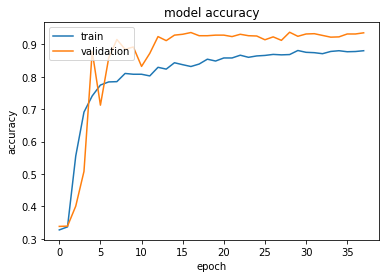

In [27]:
hist =  model.fit_generator(train_generator,
                 steps_per_epoch=nb_train_samples // batch_size,
                 epochs=epochs_fine,
                 validation_data=val_generator,
                 validation_steps=nb_val_samples // batch_size,
                 callbacks=[cb_checkpointer, cb_early_stopper, cb_plateau],
                 verbose = 1)

plot_hist(hist)

# BEST RESULT --> Epoch 32/100 388s 1s/step - loss: 0.2993 - accuracy: 0.8744 - val_loss: 0.1618 - val_accuracy: 0.9330

# Training (2 - Unlocked)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 21,912,107
Trainable params: 21,857,579
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/100
280/280 [==============================] - 480s 2s/step - loss: 0.3206 - accuracy: 0.8749 -

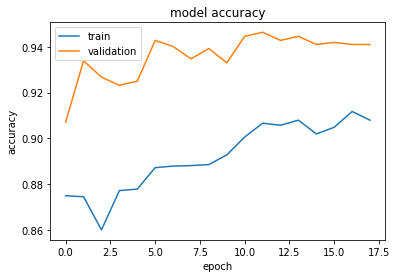

In [28]:
model.load_weights("xception.hdf5")

learning_rate = 1e-4

for layer in base_model.layers:
    if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.SeparableConv2D):
        layer.trainable = True

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

hist =  model.fit_generator(train_generator,
                 steps_per_epoch=nb_train_samples // batch_size,
                 epochs=epochs_fine,
                 validation_data=val_generator,
                 validation_steps=nb_val_samples // batch_size,
                 callbacks=[cb_checkpointer, cb_early_stopper, cb_plateau],
                 verbose = 1)

plot_hist(hist)

# Loss-wise result
# BEST RESULT--> Epoch 12/100 481s 2s/step - loss: 0.2317 - accuracy: 0.9066 - val_loss: 0.1453 - val_accuracy: 0.9464

# Testing and Creating CSV

In [29]:
model.load_weights("xception.hdf5")

test_dir = os.path.join(dataset_dir, 'test')

test_data_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input)

test_gen = test_data_gen.flow_from_directory(test_dir, target_size=(img_h, img_w), 
                                                 color_mode='rgb',
                                                 class_mode='categorical',
                                                 classes = None,
                                                 batch_size=1,
                                                 shuffle=False)
test_gen.reset()

predictions = model.predict(test_gen, verbose=1)

results = {}

images = test_gen.filenames
i = 0

for p in predictions:
  prediction = np.argmax(p)
  import ntpath
  image_name = ntpath.basename(images[i])
  results[image_name] = str(prediction)
  i = i + 1
  
create_csv(results, cwd)

Found 450 images belonging to 1 classes.
450/450 [==============================] - 10s 23ms/step
